## 用卷积神经网络训练Cifar10
For this tutorial, we will use the CIFAR10 dataset. It has the classes: ‘airplane’, ‘automobile’, ‘bird’, ‘cat’, ‘deer’, ‘dog’, ‘frog’, ‘horse’, ‘ship’, ‘truck’. The images in CIFAR-10 are of size 3x32x32, i.e. 3-channel color images of 32x32 pixels in size.

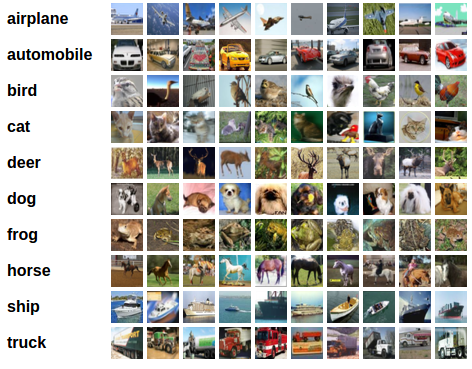

## Training an image classifier
We will do the following steps in order:
- Load and normalize the CIFAR10 training and test datasets using torchvision
- Define a Convolutional Neural Network
- Define a loss function
- Train the network on the training data
- Test the network on the test data

## 1. Load and normalize CIFAR10
Using torchvision, it's extremely easy to load CIFAR10.

In [1]:
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'
# 下载数据要加下面这两行
import ssl
ssl._create_default_https_context = ssl._create_unverified_context
import torch
import torchvision
import torchvision.transforms as transforms
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
    
print('Using PyTorch version:', torch.__version__, ' Device:', device)

Using PyTorch version: 1.13.0+cu117  Device: cuda


The output of torchvision datasets are PILImage images of range [0, 1]. We transform them to Tensors of normalized range [-1, 1].

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 32

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


Let us show some of the training images, for fun.

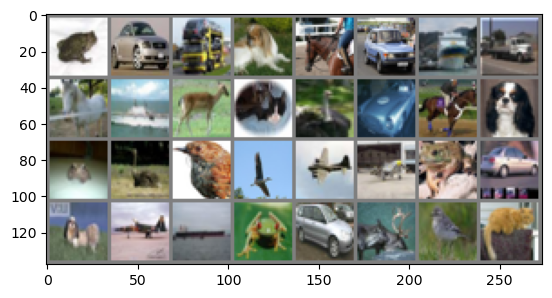

frog  car   truck dog   horse car   ship  truck horse ship  deer  cat   bird  car   horse dog   frog  bird  bird  bird  plane plane frog  car   dog   plane ship  frog  car   deer  bird  cat  


In [3]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

## 2. Define a Convolutional Neural Network


In [4]:
import torch.nn as nn
import torch.nn.functional as F


def Conv1(in_planes, places, stride=2):
    return nn.Sequential(
        nn.Conv2d(in_channels=in_planes,out_channels=places,kernel_size=7,stride=stride,padding=3, bias=False),
        nn.BatchNorm2d(places),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
    )


#BN+ReLU+1x1 Conv+BN+ReLU+3x3 Conv
class _DenseLayer(nn.Module):
    def __init__(self, inplace, growth_rate, bn_size, drop_rate=0):
        super(_DenseLayer, self).__init__()
        self.drop_rate = drop_rate
        self.dense_layer = nn.Sequential(
            nn.BatchNorm2d(inplace),
            nn.ReLU(inplace=True),
           # growth_rate：增长率。一层产生多少个特征图
            nn.Conv2d(in_channels=inplace, out_channels=bn_size * growth_rate, kernel_size=1, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(bn_size * growth_rate),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=bn_size * growth_rate, out_channels=growth_rate, kernel_size=3, stride=1, padding=1, bias=False),
        )
        self.dropout = nn.Dropout(p=self.drop_rate)
 
    def forward(self, x):
        y = self.dense_layer(x)
        if self.drop_rate > 0:
            y = self.dropout(y)
        return torch.cat([x, y], 1)

    
class DenseBlock(nn.Module):
    def __init__(self, num_layers, inplances, growth_rate, bn_size , drop_rate=0):
        super(DenseBlock, self).__init__()
        layers = []
        # 随着layer层数的增加，每增加一层，输入的特征图就增加一倍growth_rate
        for i in range(num_layers):
            layers.append(_DenseLayer(inplances + i * growth_rate, growth_rate, bn_size, drop_rate))
        self.layers = nn.Sequential(*layers)
 
    def forward(self, x):
        return self.layers(x)

    
#BN+1×1Conv+2×2AveragePooling
class _TransitionLayer(nn.Module):
    def __init__(self, inplace, plance):
        super(_TransitionLayer, self).__init__()
        self.transition_layer = nn.Sequential(
            nn.BatchNorm2d(inplace),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=inplace,out_channels=plance,kernel_size=1,stride=1,padding=0,bias=False),
            nn.AvgPool2d(kernel_size=2,stride=2),
        )
 
    def forward(self, x):
        return self.transition_layer(x)
    
    
class DenseNet(nn.Module):
    def __init__(self, init_channels=64, growth_rate=32, blocks=[3, 3, 3],num_classes=10):
        super(DenseNet, self).__init__()
        block_len = len(blocks)
        bn_size = 4
        drop_rate = 0
        self.conv1 = Conv1(in_planes=3, places=init_channels)
 
        blocks*4
 
        #第一次执行特征的维度来自于前面的特征提取
        num_features = init_channels
 
        layers = []
        
        for i in range(len(blocks)):
            layers.append(DenseBlock(num_layers=blocks[i], inplances=num_features, growth_rate=growth_rate, bn_size=bn_size, drop_rate=drop_rate))
            num_features = num_features + blocks[i] * growth_rate
            if i == block_len - 1:
                break
            layers.append(_TransitionLayer(inplace=num_features, plance=num_features // 2))
            num_features = num_features // 2
            
        self.layers = nn.Sequential(*layers)

#         num_features = num_features + blocks[-1] * growth_rate
 
        self.avgpool = nn.AvgPool2d(2, stride=1)
        self.fc = nn.Linear(num_features, num_classes)
 
    def forward(self, x):
        x = self.conv1(x)
        x = self.layers(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

net = DenseNet().to(device)
print(net)

DenseNet(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (layers): Sequential(
    (0): DenseBlock(
      (layers): Sequential(
        (0): _DenseLayer(
          (dense_layer): Sequential(
            (0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (1): ReLU(inplace=True)
            (2): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (4): ReLU(inplace=True)
            (5): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          )
          (dropout): Dropout(p=0, inplace=False)
        )
        (1): _DenseLayer(


## 3. Define a Loss function and optimizer
Let’s use a Classification Cross-Entropy loss and SGD with momentum.

In [5]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

## 4. Train the network
This is when things start to get interesting. We simply have to loop over our data iterator, and feed the inputs to the network and optimize.

In [6]:
def train(epoch, log_interval=200):
    # Set model to training mode
    net.train()
    
    # Loop over each batch from the training set
    for batch_idx, (inputs, labels) in enumerate(trainloader):
        # Copy data to GPU if needed
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Zero gradient buffers
        optimizer.zero_grad() 
        # Pass data through the network
        output = net(inputs)
        # Calculate loss
        loss = criterion(output, labels)
        # Backpropagate
        loss.backward()  
        # Update weights
        optimizer.step()    #  w - alpha * dL / dw
        
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, (batch_idx) * len(inputs), len(trainloader.dataset),
                100. * (batch_idx) / len(trainloader), loss.data.item()))

In [7]:
def validate(loss_vector, accuracy_vector):
    net.eval()
    val_loss, correct = 0, 0
    for data, target in testloader:
        data = data.to(device)
        target = target.to(device)
        output = net(data)
        val_loss += criterion(output, target).data.item()
        pred = output.data.max(1)[1] # get the index of the max log-probability
        correct += pred.eq(target.data).cpu().sum()

    val_loss /= len(testloader)
    loss_vector.append(val_loss)

    accuracy = 100. * correct.to(torch.float32) / len(testloader.dataset)
    accuracy_vector.append(accuracy)
    
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        val_loss, correct, len(testloader.dataset), accuracy))


In [8]:
%%time
epochs = 20

lossv, accv = [], []
for epoch in range(1, epochs + 1):
    train(epoch)
    validate(lossv, accv)

Train Epoch: 1 [0/50000 (0%)]	Loss: 2.291151
Train Epoch: 1 [6400/50000 (13%)]	Loss: 1.988892
Train Epoch: 1 [12800/50000 (26%)]	Loss: 1.532099
Train Epoch: 1 [19200/50000 (38%)]	Loss: 1.588855
Train Epoch: 1 [25600/50000 (51%)]	Loss: 1.614519
Train Epoch: 1 [32000/50000 (64%)]	Loss: 1.374376
Train Epoch: 1 [38400/50000 (77%)]	Loss: 1.480346
Train Epoch: 1 [44800/50000 (90%)]	Loss: 1.136951

Test set: Average loss: 1.3054, Accuracy: 5242/10000 (52%)

Train Epoch: 2 [0/50000 (0%)]	Loss: 1.084907
Train Epoch: 2 [6400/50000 (13%)]	Loss: 1.146833
Train Epoch: 2 [12800/50000 (26%)]	Loss: 1.455621
Train Epoch: 2 [19200/50000 (38%)]	Loss: 1.467712
Train Epoch: 2 [25600/50000 (51%)]	Loss: 1.059365
Train Epoch: 2 [32000/50000 (64%)]	Loss: 1.047551
Train Epoch: 2 [38400/50000 (77%)]	Loss: 1.145466
Train Epoch: 2 [44800/50000 (90%)]	Loss: 1.154696

Test set: Average loss: 1.0698, Accuracy: 6175/10000 (62%)

Train Epoch: 3 [0/50000 (0%)]	Loss: 0.762638
Train Epoch: 3 [6400/50000 (13%)]	Loss: 1.059


Test set: Average loss: 0.8499, Accuracy: 7604/10000 (76%)

Train Epoch: 19 [0/50000 (0%)]	Loss: 0.146077
Train Epoch: 19 [6400/50000 (13%)]	Loss: 0.185526
Train Epoch: 19 [12800/50000 (26%)]	Loss: 0.157742
Train Epoch: 19 [19200/50000 (38%)]	Loss: 0.146298
Train Epoch: 19 [25600/50000 (51%)]	Loss: 0.228013
Train Epoch: 19 [32000/50000 (64%)]	Loss: 0.320641
Train Epoch: 19 [38400/50000 (77%)]	Loss: 0.214181
Train Epoch: 19 [44800/50000 (90%)]	Loss: 0.530226

Test set: Average loss: 0.8676, Accuracy: 7532/10000 (75%)

Train Epoch: 20 [0/50000 (0%)]	Loss: 0.168007
Train Epoch: 20 [6400/50000 (13%)]	Loss: 0.247675
Train Epoch: 20 [12800/50000 (26%)]	Loss: 0.187752
Train Epoch: 20 [19200/50000 (38%)]	Loss: 0.122900
Train Epoch: 20 [25600/50000 (51%)]	Loss: 0.092279
Train Epoch: 20 [32000/50000 (64%)]	Loss: 0.237622
Train Epoch: 20 [38400/50000 (77%)]	Loss: 0.085877
Train Epoch: 20 [44800/50000 (90%)]	Loss: 0.121990

Test set: Average loss: 0.9161, Accuracy: 7579/10000 (76%)

CPU times: to

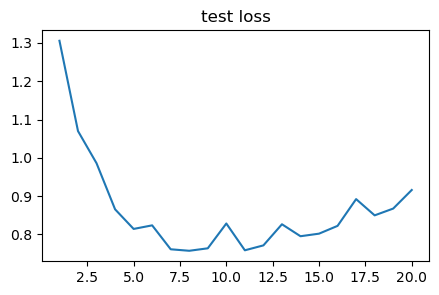

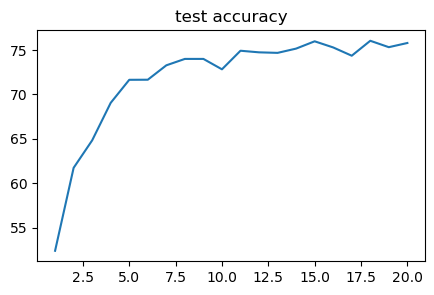

In [9]:
plt.figure(figsize=(5,3))
plt.plot(np.arange(1,epochs+1), lossv)
plt.title('test loss')

plt.figure(figsize=(5,3))
plt.plot(np.arange(1,epochs+1), accv)
plt.title('test accuracy');

Let’s quickly save our trained model:

In [10]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

## 5. Test the network on the test data
We have trained the network for 2 passes over the training dataset. But we need to check if the network has learnt anything at all.

We will check this by predicting the class label that the neural network outputs, and checking it against the ground-truth. If the prediction is correct, we add the sample to the list of correct predictions.

Okay, first step. Let us display an image from the test set to get familiar.

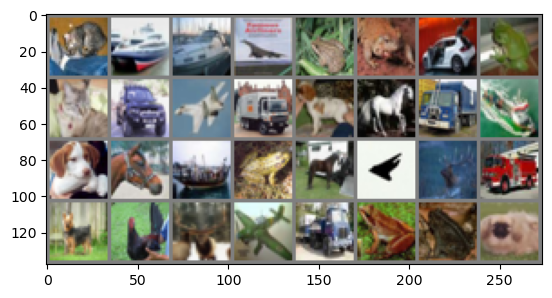

GroundTruth:  cat   ship  ship  plane


In [11]:
dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

Next, let’s load back in our saved model (note: saving and re-loading the model wasn’t necessary here, we only did it to illustrate how to do so):

In [12]:
net = DenseNet()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

Okay, now let us see what the neural network thinks these examples above are:

In [13]:
outputs = net(images)

The outputs are energies for the 10 classes. The higher the energy for a class, the more the network thinks that the image is of the particular class. So, let’s get the index of the highest energy:

In [14]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))

Predicted:  cat   ship  ship  plane


The results seem pretty good.

Let us look at how the network performs on the whole dataset.

In [15]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 74 %


That looks way better than chance, which is 10% accuracy (randomly picking a class out of 10 classes). Seems like the network learnt something.

Hmmm, what are the classes that performed well, and the classes that did not perform well:

In [16]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: plane is 76.1 %
Accuracy for class: car   is 87.5 %
Accuracy for class: bird  is 65.9 %
Accuracy for class: cat   is 54.5 %
Accuracy for class: deer  is 70.1 %
Accuracy for class: dog   is 64.6 %
Accuracy for class: frog  is 84.5 %
Accuracy for class: horse is 79.5 %
Accuracy for class: ship  is 86.1 %
Accuracy for class: truck is 79.0 %
